# CW2 - Machine/Deep learning algorithms in cryptocurrency trading

### Data set selection and definition of ML objective

**Objectives**:

1. Use machine/deep learning to predict bitcoin closing price in USD(United States Dollar). 

2. Investigate which features are the most important when it comes to making the above prediction. 

**Dataset chosen**:

[Kaggle - Top 100 Cryptocurrencies Historical Dataset](https://www.kaggle.com/datasets/kaushiksuresh147/top-10-cryptocurrencies-historical-dataset/data)

In [206]:
# First lets set the path for Kaggle API
import os

kaggle_dir = os.path.join(os.path.expanduser('~'), '.kaggle')
kaggle_file = os.path.join(kaggle_dir, 'kaggle.json')

# Check if the .kaggle directory exists before creating it
if not os.path.exists(kaggle_dir):
    os.system("mkdir -p " + kaggle_dir)
    print("Created directory " + kaggle_dir)
else:
    print("Directory " + kaggle_dir + " already exists")

# Check if the kaggle.json file exists in the .kaggle directory before moving it
if not os.path.exists(kaggle_file):
    os.system("mv kaggle.json " + kaggle_file)
    os.system("chmod 600 " + kaggle_file)
    print(f"Moved kaggle.json to {kaggle_file} and changed its permissions")
else:
    print("File " + kaggle_file + " already exists, changing its permissions not needed")


# Check if the zip file exists before downloading
if not os.path.exists('top-10-cryptocurrencies-historical-dataset.zip'):
    !kaggle datasets download -d kaushiksuresh147/top-10-cryptocurrencies-historical-dataset
    !unzip top-10-cryptocurrencies-historical-dataset.zip
    print("Downloaded and unzipped top-10-cryptocurrencies-historical-dataset.zip")
else:
    print("File top-10-cryptocurrencies-historical-dataset.zip already exists")

Directory /home/realtime/.kaggle already exists
File /home/realtime/.kaggle/kaggle.json already exists, changing its permissions not needed
File top-10-cryptocurrencies-historical-dataset.zip already exists


### Data preparation and Analysis

In [207]:
# Loading the data into dataframes
import pandas as pd

# List of cryptocurrencies
cryptos = ['bitcoin', 'litecoin', 'ethereum', 'xrp']

# Dictionary to store the dataframes
dfs = {}

# Load each CSV file into a DataFrame and store it in the dictionary
for crypto in cryptos:
    df_name = 'raw_' + crypto + '_pd'
    dfs[df_name] = pd.read_csv(f'Top 100 Crypto Coins/{crypto}.csv')
    print(f"Top 5 rows of {df_name}:")
    print(dfs[df_name].head())
    print("\n")

    print(f"Statistics for {df_name}:")
    print(dfs[df_name].describe())
    print("\n")
    
    print(f"Missing values in {df_name}:")
    print(dfs[df_name].isnull().sum())
    print("\n")


Top 5 rows of raw_bitcoin_pd:
         Date  Open  High  Low  Close  Volume Currency
0  2010-07-18   0.0   0.1  0.1    0.1      75      USD
1  2010-07-19   0.1   0.1  0.1    0.1     574      USD
2  2010-07-20   0.1   0.1  0.1    0.1     262      USD
3  2010-07-21   0.1   0.1  0.1    0.1     575      USD
4  2010-07-22   0.1   0.1  0.1    0.1    2160      USD


Statistics for raw_bitcoin_pd:
               Open          High           Low         Close        Volume
count   4420.000000   4420.000000   4420.000000   4420.000000  4.420000e+03
mean    8302.221855   8531.971380   8043.473869   8306.969457  1.395788e+07
std    14598.398937  14992.605971  14146.499234  14599.046649  1.645973e+08
min        0.000000      0.100000      0.000000      0.100000  0.000000e+00
25%      122.500000    129.975000    118.300000    122.800000  3.013600e+04
50%      683.600000    706.500000    657.550000    685.000000  6.762050e+04
75%     8877.250000   9122.700000   8666.900000   8886.075000  1.769402e+05

In [208]:
import plotly.graph_objects as go

# Get the DataFrame for Bitcoin
df_bitcoin_1 = dfs['raw_bitcoin_pd'].copy()

# Create a candlestick plot
fig = go.Figure(data=[go.Candlestick(x=df_bitcoin_1['Date'],
                open =df_bitcoin_1['Open'],
                high =df_bitcoin_1['High'],
                low  =df_bitcoin_1['Low'],
                close=df_bitcoin_1['Close'])])

# Set the title and axis labels
fig.update_layout(
    title='Bitcoin Candlestick Chart',
    xaxis_title='Date',
    yaxis_title='Price(USD)',
)

# Show the plot
fig.show()

In [209]:
# Let's analyse Bitcoin's price for t

df_bitcoin_1['Date'] = pd.to_datetime(df_bitcoin_1['Date'])

# Get the date one year ago from the latest date in the DataFrame
one_year_ago = df_bitcoin_1['Date'].max() - pd.DateOffset(years=1)

# Filter the DataFrame to include only the data from the last year
df_bitcoin_last_year = df_bitcoin_1[df_bitcoin_1['Date'] >= one_year_ago]

# Create a candlestick plot for the last year's worth of data
fig = go.Figure(data=[go.Candlestick(x=df_bitcoin_last_year['Date'],
                open=df_bitcoin_last_year['Open'],
                high=df_bitcoin_last_year['High'],
                low=df_bitcoin_last_year['Low'],
                close=df_bitcoin_last_year['Close'])])

# Set the title and axis labels
fig.update_layout(
    title='Bitcoin Candlestick Chart (Last Year)',
    xaxis_title='Date',
    yaxis_title='Price(USD)',
)

# Show the plot
fig.show()

/usr/lib/python3/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/lib/python3/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/lib/python3/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

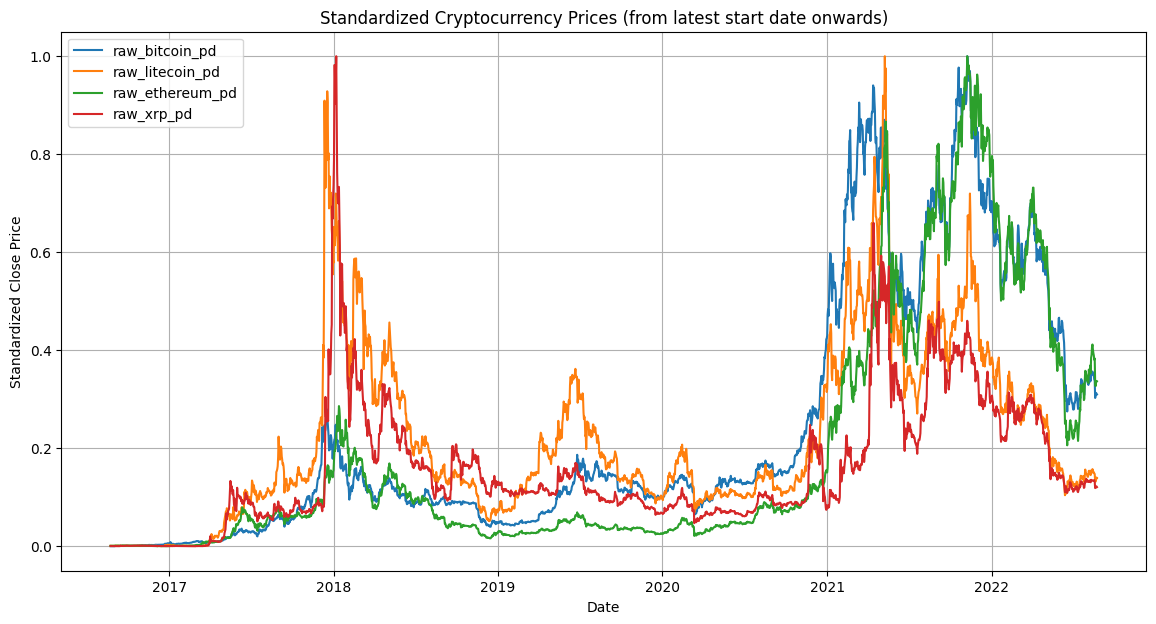

In [210]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

dfs_copied = dfs.copy()
scaler = MinMaxScaler()

# Convert 'Date' to datetime and set it as index
for df_name, df in dfs_copied.items():
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

# Find the latest starting date among all the cryptocurrencies
latest_start_date = max(df.index.min() for df in dfs_copied.values())

# Plot each cryptocurrency's closing price
plt.figure(figsize=(14, 7))
for df_name, df in dfs_copied.items():
    df = df.loc[df.index >= latest_start_date]  # Filter data from the latest start date onwards
    df.loc[:, 'Close'] = scaler.fit_transform(df[['Close']])  # Standardize 'Close' price
    plt.plot(df.index, df['Close'], label=df_name)

plt.title('Standardized Cryptocurrency Prices (from latest start date onwards)')
plt.xlabel('Date')
plt.ylabel('Standardized Close Price')
plt.legend()
plt.grid(True)
plt.show()

### Model Selection and Training

#### Building a model (1)

            Open  High  Low  Close  Volume Currency  SMA_50  SMA_200  \
Date                                                                   
2011-02-02   0.7   0.8  0.7    0.7    5627      USD   0.336   0.1945   
2011-02-03   0.7   0.8  0.7    0.7    8525      USD   0.346   0.1975   
2011-02-04   0.7   0.9  0.7    0.8   42222      USD   0.356   0.2010   
2011-02-05   0.8   0.9  0.8    0.9   15787      USD   0.370   0.2050   
2011-02-06   0.9   0.9  0.8    0.9    8744      USD   0.384   0.2090   
2011-02-07   0.9   0.9  0.8    0.9    2264      USD   0.398   0.2130   

              EMA_50   EMA_200      MACD  Signal_Line    RSI  Daily_Return  \
Date                                                                         
2011-02-02  0.362980  0.231407  0.074939     0.045136  100.0      0.000000   
2011-02-03  0.376197  0.236069  0.085494     0.053207  100.0      0.000000   
2011-02-04  0.392816  0.241681  0.100766     0.062719  100.0      0.142857   
2011-02-05  0.412706  0.248231  0

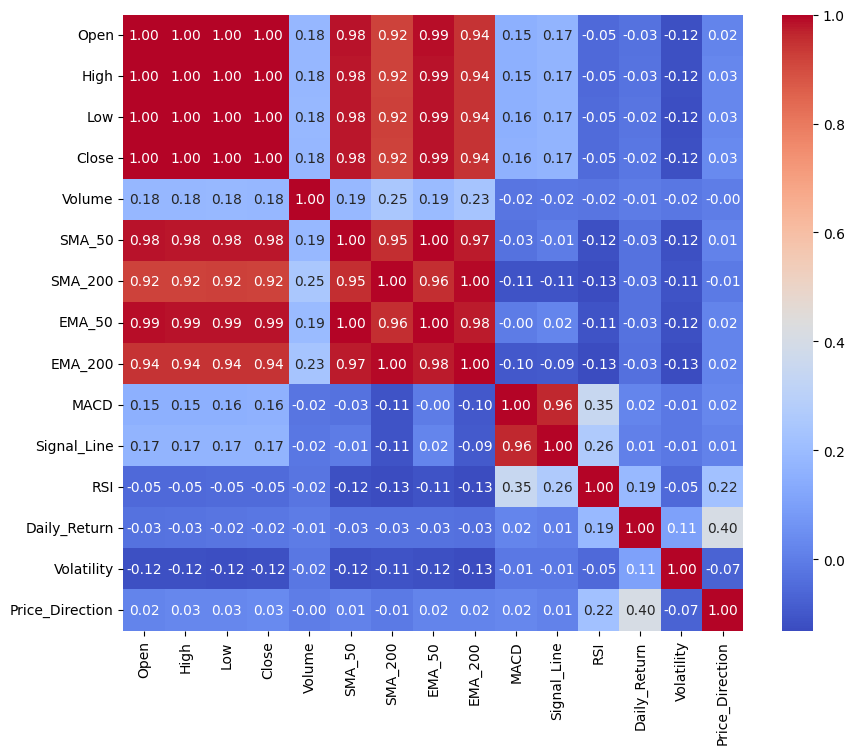

                    Close
Close            1.000000
High             0.999556
Low              0.999468
Open             0.998996
EMA_50           0.985747
SMA_50           0.981267
EMA_200          0.943088
SMA_200          0.919309
Volume           0.182242
Signal_Line      0.169732
MACD             0.156964
Price_Direction  0.033989
Daily_Return    -0.019557
RSI             -0.048863
Volatility      -0.120992


In [211]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# We need to add more features to the model to improve its accuracy
# Assuming dfs['raw_bitcoin_pd'] is your DataFrame for Bitcoin
df_bitcoin_2 = dfs['raw_bitcoin_pd'].copy()

# Calculate Moving Averages
df_bitcoin_2['SMA_50']  = df_bitcoin_2['Close'].rolling(window=50).mean()
df_bitcoin_2['SMA_200'] = df_bitcoin_2['Close'].rolling(window=200).mean()

# Calculate Exponential Moving Averages
df_bitcoin_2['EMA_50'] = df_bitcoin_2['Close'].ewm(span=50, adjust=False).mean()
df_bitcoin_2['EMA_200'] = df_bitcoin_2['Close'].ewm(span=200, adjust=False).mean()

# Calculate MACD
# MACD Line = 12-day EMA - 26-day EMA
# Signal Line = 9-day EMA of MACD Line
# MACD Histogram = MACD Line - Signal Line
EMA_12 = df_bitcoin_2['Close'].ewm(span=12, adjust=False).mean()
EMA_26 = df_bitcoin_2['Close'].ewm(span=26, adjust=False).mean()
df_bitcoin_2['MACD'] = EMA_12 - EMA_26
df_bitcoin_2['Signal_Line']    = df_bitcoin_2['MACD'].ewm(span=9, adjust=False).mean()

# Calculate RSI
delta = df_bitcoin_2['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
RS = gain / loss
df_bitcoin_2['RSI'] = 100 - (100 / (1 + RS))

# Calculate Volatility (as the standard deviation of daily returns)
df_bitcoin_2['Daily_Return'] = df_bitcoin_2['Close'].pct_change()
df_bitcoin_2['Volatility']   = df_bitcoin_2['Close'].pct_change().rolling(window=50).std() * np.sqrt(50)

# If today's close is higher than yesterday's close, price direction is 1 (up), otherwise 0 (down or unchanged)
df_bitcoin_2['Price_Direction'] = (df_bitcoin_2['Close'] > df_bitcoin_2['Close'].shift(1)).astype(int)

# Display the head of the DataFrame to verify the new columns
print(df_bitcoin_2.iloc[199:205])


# Calculate the correlation matrix
correlation_matrix = df_bitcoin_2.corr()

# Focus on the 'High' and 'Low' columns
correlation_with_target = correlation_matrix[['Close']].sort_values(by='Close', ascending=False)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()
# Print the correlation values
print(correlation_with_target)

In [212]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

def feature_importance_verifier(df, feature):
    # Ensure specified columns exist in the DataFrame, then drop them if they do
    y = df[feature]  # Target variable
    columns_to_drop = ['Date', 'Currency', 'Close', feature]
    X = df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)

    # Initialize the random forest
    xgb = XGBRegressor(n_estimators=100, random_state=42)

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    # Perform cross-validation
    cv_scores = cross_val_score(xgb, X, y, cv=tscv, scoring='neg_mean_squared_error')

    # Print cross-validation scores
    print(f"Cross-validation scores (MSE): {-cv_scores}")
    print(f"Mean cross-validation score (MSE): {-cv_scores.mean()}")

    # Fit the model to the data
    xgb.fit(X, y)

    # Extract feature importance
    importances = xgb.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print(f"Feature ranking for {feature}:")
    for f in range(X.shape[1]):
        print(f"{f + 1}. feature {X.columns[indices[f]]} ({importances[indices[f]]})")
  

In [213]:
# We know our data has NaN values, so we need to clean it before training the models
initial_row_count = len(df_bitcoin_2)
df_bitcoin_2_clean = df_bitcoin_2.dropna()
rows_removed = initial_row_count - len(df_bitcoin_2_clean)
feature_importance_verifier(df_bitcoin_2_clean.copy(), 'Close')
print(f"Number of rows removed: {rows_removed}")

Cross-validation scores (MSE): [1.93950799e+05 1.50460713e+02 3.58391791e+07 7.59625990e+04
 6.91743586e+08]
Mean cross-validation score (MSE): 145570565.78002688
Feature ranking for Close:
1. feature Low (0.7557322382926941)
2. feature High (0.2399614006280899)
3. feature Open (0.0038125766441226006)
4. feature Daily_Return (0.0001877458271337673)
5. feature SMA_50 (8.049754978856072e-05)
6. feature RSI (3.808031033258885e-05)
7. feature EMA_50 (3.686710988404229e-05)
8. feature Volatility (3.4820484870579094e-05)
9. feature SMA_200 (3.2147068850463256e-05)
10. feature MACD (2.371896516706329e-05)
11. feature EMA_200 (2.3634534954908304e-05)
12. feature Volume (1.992719444388058e-05)
13. feature Signal_Line (1.6315765606123023e-05)
14. feature Price_Direction (0.0)
Number of rows removed: 203


#### Building a baseline model LSTM

In [214]:
import numpy as np
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.dates as mdates


def plot_loss(history, title):
    """
    Plots the training loss and validation loss against the number of epochs.

    Parameters:
    - history: The history object returned by the fit method of a Keras model.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()



def plot_model_predictions(models, X_val_scaled, y_val_scaled, dates_val, scaler_y):
    """
    Plots actual data and predictions from multiple models.
    """
    # Initialize plot
    plt.figure(figsize=(12, 6))
    
    # Plot actual data
    actual = scaler_y.inverse_transform(y_val_scaled)
    plt.scatter(dates_val, actual, label='Actual', color='blue', s=10)  # Use scatter plot for actual data
    plt.plot(dates_val, actual, color='blue', linewidth=1, alpha=0.7)  # Connect actual data points with a line
    
    # Generate and plot predictions for each model
    for i, model in enumerate(models):
        # Generate predictions
        predictions_scaled = model.predict(X_val_scaled)
        predictions = scaler_y.inverse_transform(predictions_scaled)
        
        # Plot predictions with scatter and lines
        plt.scatter(dates_val, predictions, label=f'Model {(i+1)} Predictions', s=10)  # Scatter plot for predictions
        plt.plot(dates_val, predictions, linewidth=1, alpha=0.7)  # Connect prediction dots with a line
    
    # Plot formatting
    plt.title('Actual vs. Predicted Prices(Validation Set)')
    plt.xlabel('Date')
    plt.ylabel('Price(USD)')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate dates for better visibility
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format dates
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))  # Adjust interval as needed
    plt.gcf().autofmt_xdate()  # Beautify the x-labels
    plt.tight_layout()
    plt.show()


def extract_model_details(model):
    """
    Extracts details from a keras Sequential model with a specific architecture:
    - Two recurrent layers (potentially bidirectional) each followed by a Dropout layer, and a final Dense layer.
    """
    details = ""
    for layer in model.layers:
        if hasattr(layer, 'layer'):  # Check for bidirectionality
            layer_type = f"Bi{layer.layer.__class__.__name__}"
            units = layer.layer.units
        else:
            layer_type = layer.__class__.__name__
            units = layer.units if 'units' in layer.get_config() else 'N/A'
        
        dropout_rate = 'N/A'
        if 'rate' in layer.get_config():
            dropout_rate = layer.rate
        
        details += f"{layer_type} with units: {units}, Dropout: {dropout_rate}\n"
    
    return details


def plot_test_predictions(model, X_test_scaled, y_test_scaled, dates_test, scaler_y):
    """
    Plots actual test dataset vs predicted results.
    """
    # Generate predictions
    predictions_scaled = model.predict(X_test_scaled)
    predictions = scaler_y.inverse_transform(predictions_scaled)
    actual = scaler_y.inverse_transform(y_test_scaled)

    # Compute Metrics
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    mae = mean_absolute_error(actual, predictions)
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    smape = 100 * np.mean(2 * np.abs(predictions - actual) / (np.abs(actual) + np.abs(predictions)))

    # Save metrics to file
    model_details = extract_model_details(model)
    with open("model_test_data_metrics.txt", "a") as file:
        file.write(model_details)
        file.write(f"RMSE: {rmse}, MAE: {mae}, MAPE: {mape}%, sMAPE: {smape}%\n\n")

    # Initialize plot
    
    plt.figure(figsize=(12, 6))
    plt.plot(dates_test, actual, label='Actual', color='blue', linewidth=1)
    plt.plot(dates_test, predictions, label='Predicted', color='red', linestyle='--', linewidth=1)
    plt.title('Bitcoin price predictions (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate dates for better visibility
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Show year-month only for less clutter
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Place a tick on the first day of each month
    plt.gcf().autofmt_xdate()  # Beautify the x-labels
    plt.tight_layout()
    plt.show()
    

In [215]:
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.models import Sequential
from keras_tuner import HyperModel
from keras_tuner.tuners import Hyperband
import json

class GRUHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(GRU(units=hp.Int('units', min_value=32, max_value=512, step=32),
                      return_sequences=True,
                      input_shape=self.input_shape))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(GRU(units=hp.Int('units', min_value=32, max_value=512, step=32)))
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Dense(1))
        
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model
    
def find_and_save_hyperparameter(df, features, target, train_percent, val_percent):
    # Prepare the data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    X = df[features]
    y = df[[target]]  # Keeping it as DataFrame
    
    # Scale features and target
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    
    # Reshape for LSTM [samples, time steps, features]
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
    
    # Calculate the number of rows for training and validation
    total_rows = len(df)
    train_end = int(total_rows * train_percent)
    val_end = train_end + int(total_rows * val_percent)
    
    # Split data
    X_train_scaled = X_scaled[:train_end]
    y_train_scaled = y_scaled[:train_end]
    X_val_scaled = X_scaled[train_end:val_end]
    y_val_scaled = y_scaled[train_end:val_end]

    input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])

    tuner = Hyperband(
        GRUHyperModel(input_shape),
        objective='val_loss',
        max_epochs=20,
        directory='my_dir',
        project_name='gru_tuning'
    )

    tuner.search(X_train_scaled, y_train_scaled, epochs=10, validation_data=(X_val_scaled, y_val_scaled))

    # Save the tuning results to a file
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model_metrics = {
        'units': best_hps.get('units'),
        'dropout_1': best_hps.get('dropout_1'),
        'dropout_2': best_hps.get('dropout_2')
    }

    with open('model_hyperparameter_tuning.txt', 'w') as f:
        json.dump(model_metrics, f)
        

In [216]:
features = ['EMA_50', 'EMA_200', 'SMA_200', 'SMA_50', 'MACD', 'Signal_Line']
target = 'Close'

train_split      = 0.80
validation_split = 0.10

#find_and_save_hyperparameter(df_bitcoin_2_clean.copy(), features, target, train_split, validation_split)

In [217]:
from tensorflow.keras.layers import Bidirectional, GRU, Dropout, Dense

def prepare_data(df, features, target, train_percent, val_percent):
    # Prepare the data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    if df.index.name != 'Date':
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
    
    X = df[features]
    y = df[[target]]  # Keeping it as DataFrame

    # Calculate the number of rows for training and validation
    total_rows = len(df)
    train_end = int(total_rows * train_percent)
    val_end = train_end + int(total_rows * val_percent)

    test_y = y[val_end:]  # Extract test target values
    for feature in features:
        feature_raw = df[[feature]][val_end:]
        rmse = np.sqrt(mean_squared_error(test_y, feature_raw))
        print(f"RMSE for '{feature}': {rmse} vs target: '{target}', length of data {len(feature_raw)}")

    # Scale features and target
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    
    # Reshape for LSTM [samples, time steps, features]
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
    
    # Split data
    X_train_scaled = X_scaled[:train_end]
    y_train_scaled = y_scaled[:train_end]
    X_val_scaled = X_scaled[train_end:val_end]
    y_val_scaled = y_scaled[train_end:val_end]

    return X_scaled, y_scaled, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, scaler_y

def complete_workflow_and_plot(df, models, features, target, train_percent, val_percent, epochs=20, batch_size=32):
    """
    This function encapsulates the entire workflow: preparing data, building and training the model,
    and plotting the predictions alongside actual values with dates on the x-axis.
    """
    X_scaled, y_scaled, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, scaler_y = prepare_data(df, 
                                                                                                            features, 
                                                                                                            target, 
                                                                                                            train_percent, 
                                                                                                            val_percent)
    
    # Calculate the number of rows for training and validation
    total_rows = len(df)
    train_end = int(total_rows * train_percent)
    val_end = train_end + int(total_rows * val_percent)
    
    X_test = X_scaled[val_end:]
    y_test = y_scaled[val_end:]
    dates_test = df.index[val_end:]  # Extract test dates
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    for i, model in enumerate(models, start=1):  # start=1 begins counting from 1
        model.compile(optimizer='adam', loss='mean_squared_error') # compile the models first !
        history = model.fit(X_train_scaled, 
                            y_train_scaled, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            validation_data=(X_val_scaled, y_val_scaled), 
                            verbose=0, 
                            callbacks=[early_stopping])
        
        #plot_loss(history, f"Model {i} Training/Validation Loss")
        plot_test_predictions(model, X_test, y_test, dates_test, scaler_y)

    # Now plot the predictions alongside the actual validation data
    #plot_model_predictions(models, X_val_scaled, y_val_scaled, dates_val, scaler_y)

RMSE for Low: 1443.698100934896 vs targetClose, length of data 423
RMSE for High: 1393.7700289987672 vs targetClose, length of data 423
RMSE for Open: 1439.6225984709913 vs targetClose, length of data 423
RMSE for Daily_Return: 41939.26397228145 vs targetClose, length of data 423
RMSE for SMA_50: 6018.149102367627 vs targetClose, length of data 423


RMSE for Low: 1443.698100934896 vs targetClose, length of data 423
RMSE for High: 1393.7700289987672 vs targetClose, length of data 423
RMSE for Open: 1439.6225984709913 vs targetClose, length of data 423
RMSE for Daily_Return: 41939.26397228145 vs targetClose, length of data 423
RMSE for SMA_50: 6018.149102367627 vs targetClose, length of data 423
14/14 [==============================] - 0s 3ms/step


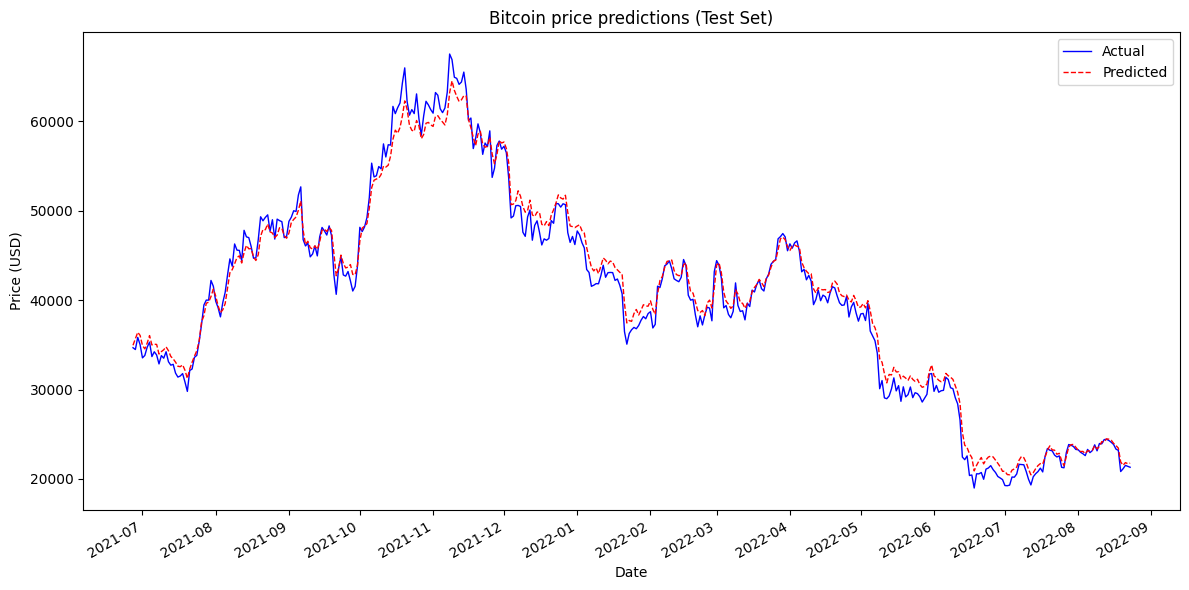

KeyboardInterrupt: 

In [218]:
features = ['Low', 'High', 'Open', 'Daily_Return', 'SMA_50']
target   = 'Close'

train_split      = 0.80
validation_split = 0.10

X_scaled, y_scaled, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, scaler_y = prepare_data(df_bitcoin_2_clean.copy(), 
                                                                                                        features, 
                                                                                                        target, 
                                                                                                        train_split, 
                                                                                                        validation_split)

# Build the model 1
model1 = Sequential([
    GRU(352, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.3),
    GRU(512),
    Dropout(0.2),
    Dense(1)
])

# Build the model 2
model2 = Sequential([
    LSTM(448, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.1),
    LSTM(448),
    Dropout(0.1),
    Dense(1)
])

# Build the model 3
model3 = Sequential([
    Bidirectional(GRU(320, return_sequences=True), input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.40),
    Bidirectional(GRU(352)),  # Note: return_sequences defaults to False here
    Dropout(0.20),
    Dense(1)
])

# Train the models then plot their losses
models = [model1, model2, model3]

complete_workflow_and_plot(
    df=df_bitcoin_2_clean.copy(),
    models=models,
    features=features,
    target=target,
    train_percent=train_split,
    val_percent=validation_split,
    epochs=50,
    batch_size=32
)

### Investigating Feature selection

Open               2191
High               2191
Low                2191
bitcoin_Close      2191
Volume             2191
SMA_50             2191
SMA_200            2191
EMA_50             2191
EMA_200            2191
MACD               2191
Signal_Line        2191
RSI                2191
Daily_Return       2191
Volatility         2191
Price_Direction    2191
litecoin_Close     2191
ethereum_Close     2191
xrp_Close          2191
dtype: int64


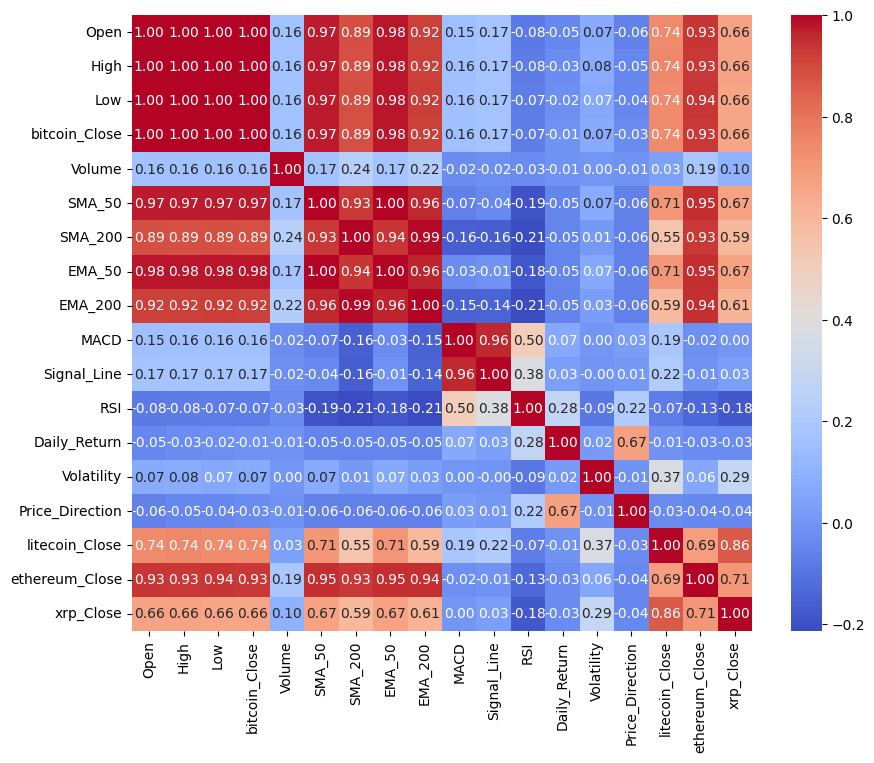

                 bitcoin_Close
bitcoin_Close         1.000000
High                  0.999355
Low                   0.999227
Open                  0.998540
EMA_50                0.979260
SMA_50                0.972914
ethereum_Close        0.933197
EMA_200               0.917142
SMA_200               0.885171
litecoin_Close        0.742338
xrp_Close             0.663275
Signal_Line           0.173883
Volume                0.162915
MACD                  0.159929
Volatility            0.073214
Daily_Return         -0.006410
Price_Direction      -0.032439
RSI                  -0.071419
Cross-validation scores (MSE): [2.81362244e+07 4.72832188e+04 2.65230582e+04 5.22406348e+08
 4.84932091e+06]
Mean cross-validation score (MSE): 111093139.92879029
Feature ranking for bitcoin_Close:
1. feature Low (0.6701481938362122)
2. feature High (0.32886335253715515)
3. feature Daily_Return (0.00022822081518825144)
4. feature Open (0.00019623214029707015)
5. feature SMA_50 (0.00013504728849511594)
6. fea

In [ ]:
df_bitcoin_features = df_bitcoin_2_clean.copy()
df_bitcoin_features = df_bitcoin_features.drop(['Currency'], axis=1)
df_bitcoin_features = df_bitcoin_features.rename(columns={'Close': 'bitcoin_Close'})
cryptos_prices_to_copy = ['litecoin', 'ethereum', 'xrp']

# Find the latest starting date among all the cryptocurrencies
latest_start_date = max(df.index.min() for df in [df_bitcoin_features] + [dfs[f'raw_{crypto}_pd'] for crypto in cryptos_prices_to_copy])

# Filter df_bitcoin_features from the latest start date onwards
df_bitcoin_features = df_bitcoin_features[df_bitcoin_features.index >= latest_start_date]

for crypto in cryptos_prices_to_copy:
    # Filter each crypto DataFrame from the latest start date onwards and add 'Close' price to df_bitcoin_features
    df_bitcoin_features[f'{crypto}_Close'] = dfs[f'raw_{crypto}_pd'].loc[dfs[f'raw_{crypto}_pd'].index >= latest_start_date, 'Close']

print(df_bitcoin_features.count())

# Calculate the correlation matrix
correlation_matrix = df_bitcoin_features.corr()
correlation_with_target = correlation_matrix[['bitcoin_Close']].sort_values(by='bitcoin_Close', ascending=False)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()
print(correlation_with_target)
feature_importance_verifier(df_bitcoin_features.copy(), 'bitcoin_Close')


7/7 [==============================] - 0s 2ms/step


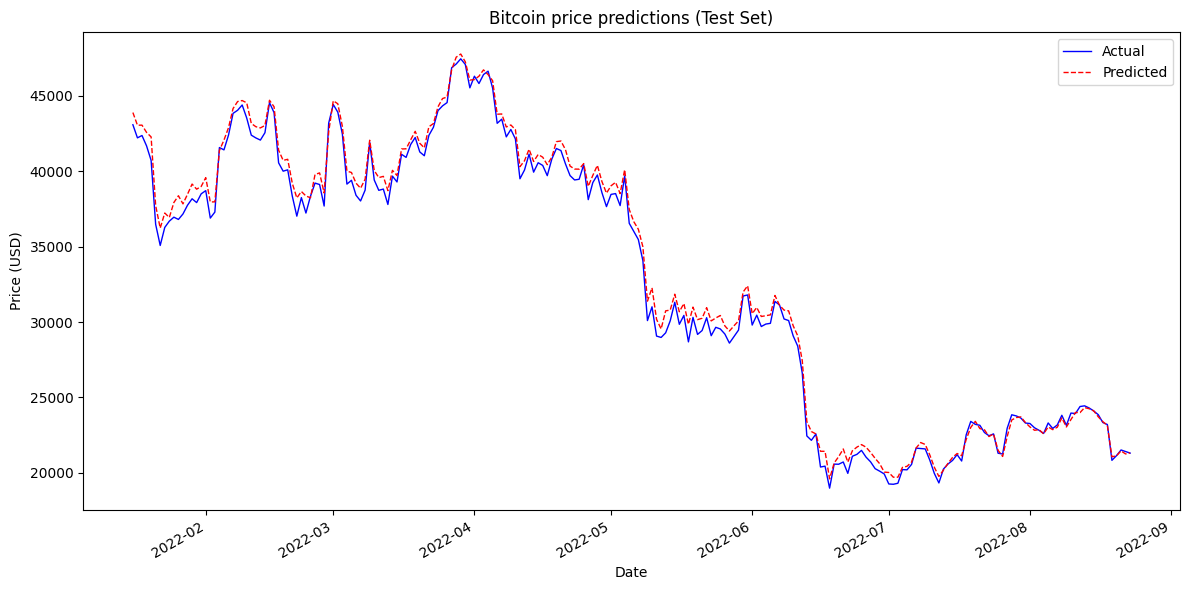

7/7 [==============================] - 0s 2ms/step


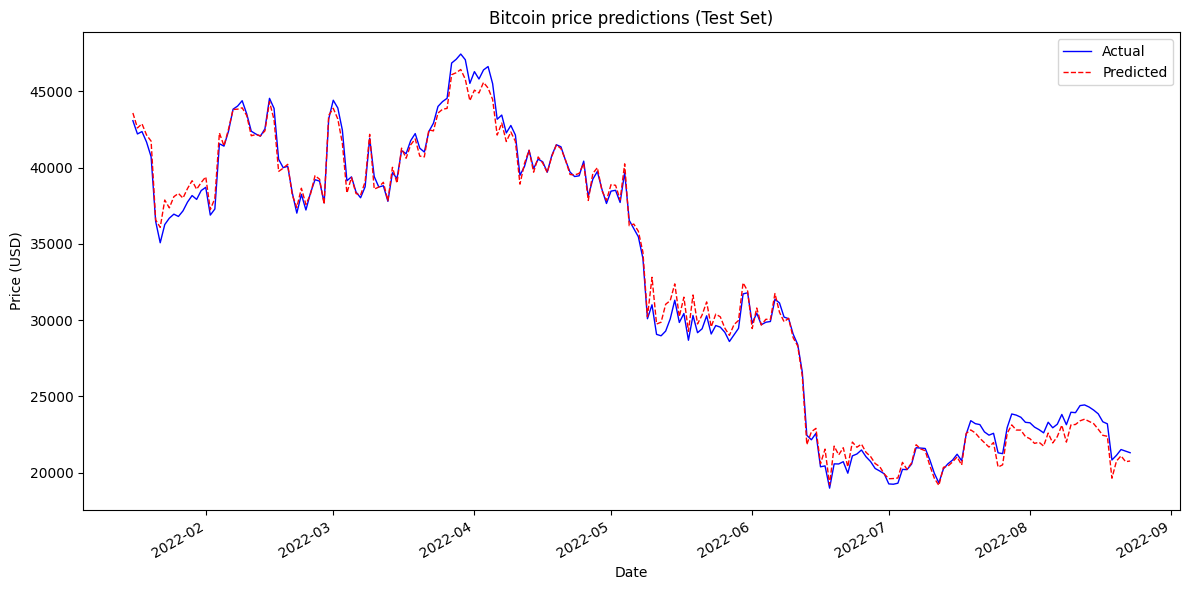

7/7 [==============================] - 1s 5ms/step


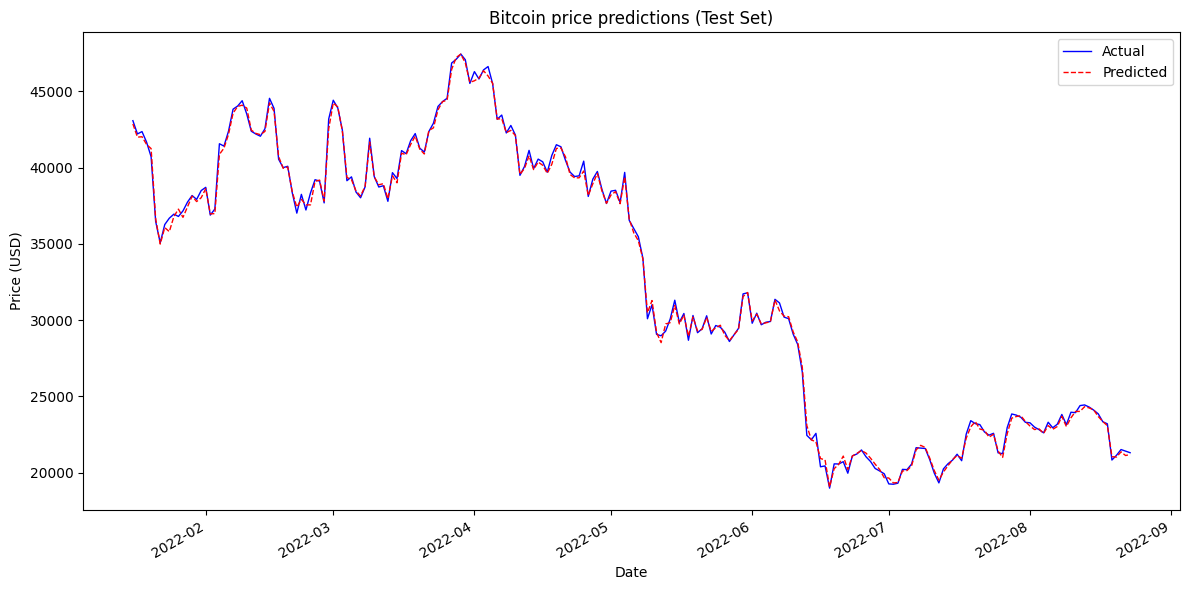

In [ ]:
features = ['Low', 'High', 'Open', 'Daily_Return', 'SMA_50', 'litecoin_Close', 'ethereum_Close']
target   = 'bitcoin_Close'

X_scaled, y_scaled, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, scaler_y = prepare_data(df_bitcoin_features.copy(), 
                                                                                                        features, 
                                                                                                        target, 
                                                                                                        train_split, 
                                                                                                        validation_split)

model1 = Sequential([
    GRU(480, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.4),
    GRU(160),
    Dropout(0.2),
    Dense(1)
])
model2 = Sequential([
    LSTM(224, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.4),
    LSTM(384),
    Dropout(0.3),
    Dense(1)
])
model3 = Sequential([
    Bidirectional(GRU(480, return_sequences=True), input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.30),
    Bidirectional(GRU(320)),  
    Dropout(0.1),
    Dense(1)
])
models = [model1, model2, model3]
complete_workflow_and_plot(
    df=df_bitcoin_features.copy(),
    models=models,
    features=features,
    target=target,
    train_percent=train_split,
    val_percent=validation_split,
    epochs=50,
    batch_size=32
)

7/7 [==============================] - 0s 2ms/step


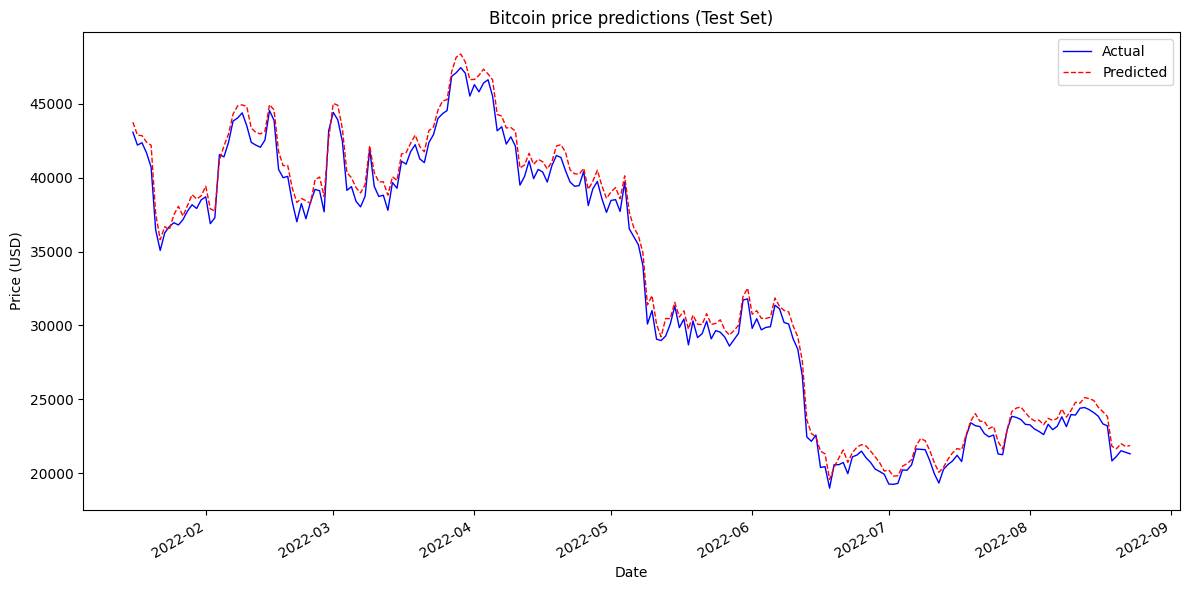

7/7 [==============================] - 0s 3ms/step


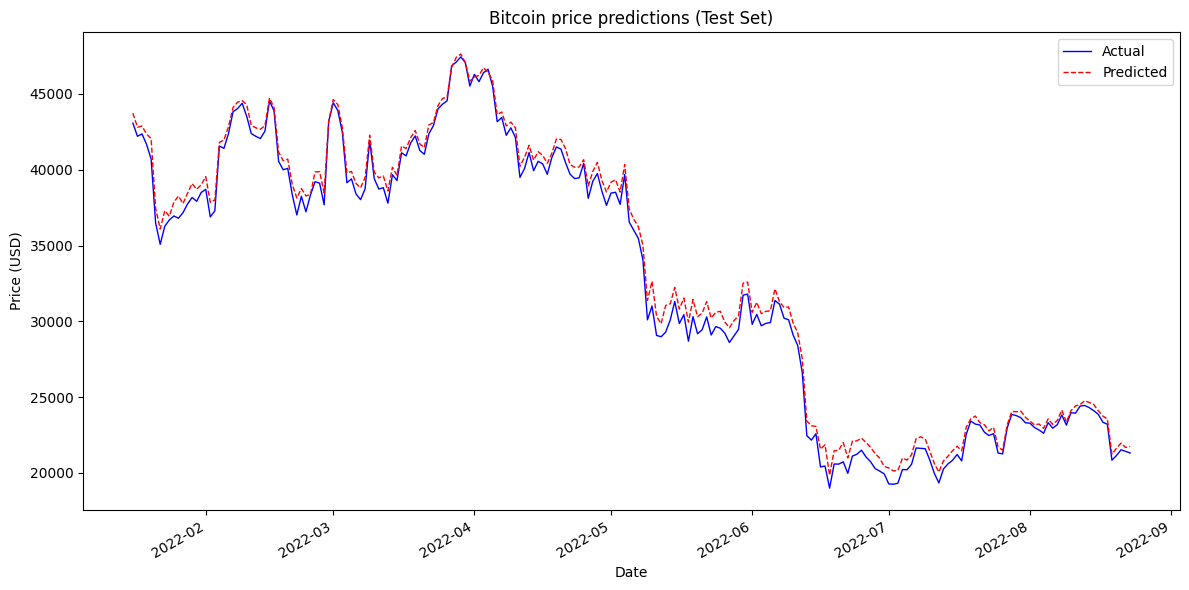

7/7 [==============================] - 1s 3ms/step


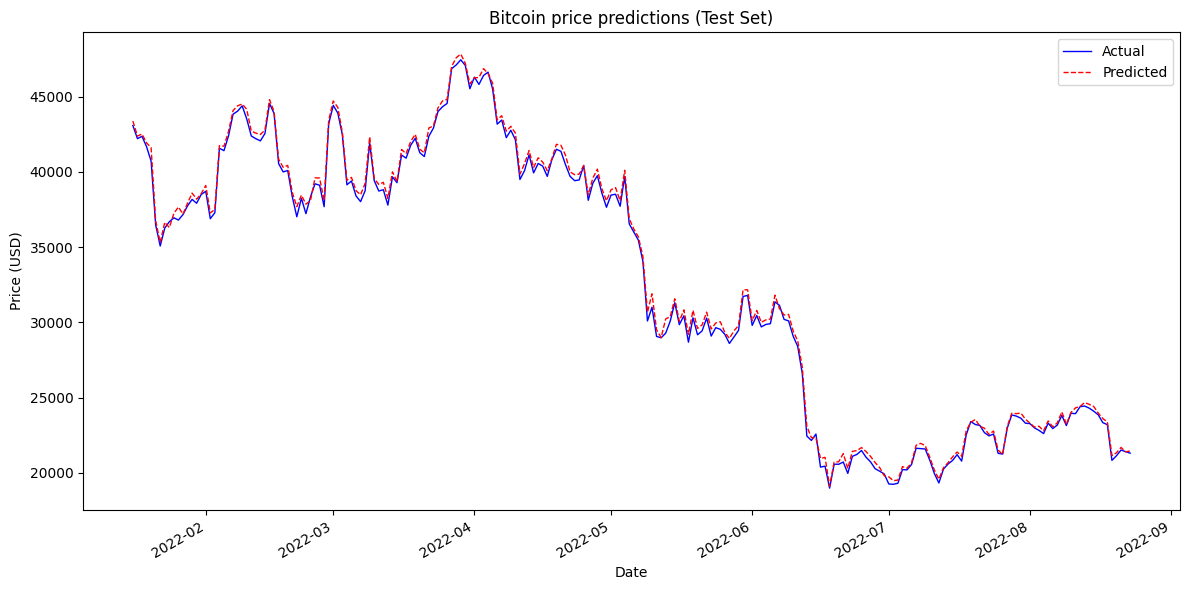

In [ ]:
features = ['Low', 'High', 'Open', 'Daily_Return', 'SMA_50']
target   = 'bitcoin_Close'

X_scaled, y_scaled, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, scaler_y = prepare_data(df_bitcoin_features.copy(), 
                                                                                                        features, 
                                                                                                        target, 
                                                                                                        train_split, 
                                                                                                        validation_split)

model1 = Sequential([
    GRU(288, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.30),
    GRU(384),
    Dropout(0.30),
    Dense(1)
])
model2 = Sequential([
    LSTM(448, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.10),
    LSTM(352),
    Dropout(0.30),
    Dense(1)
])
model3 = Sequential([
    Bidirectional(GRU(352, return_sequences=True), input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.20),
    Bidirectional(GRU(224)),  
    Dropout(0.30),
    Dense(1)
])
models = [model1, model2, model3]

complete_workflow_and_plot(
    df=df_bitcoin_features.copy(),
    models=models,
    features=features,
    target=target,
    train_percent=train_split,
    val_percent=validation_split,
    epochs=50,
    batch_size=32
)

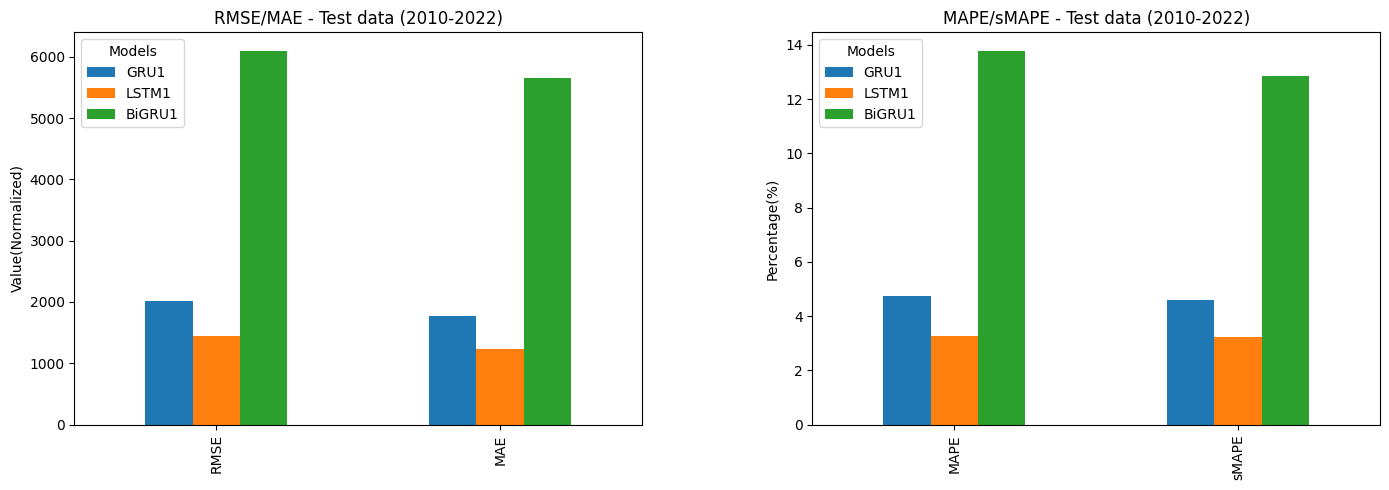

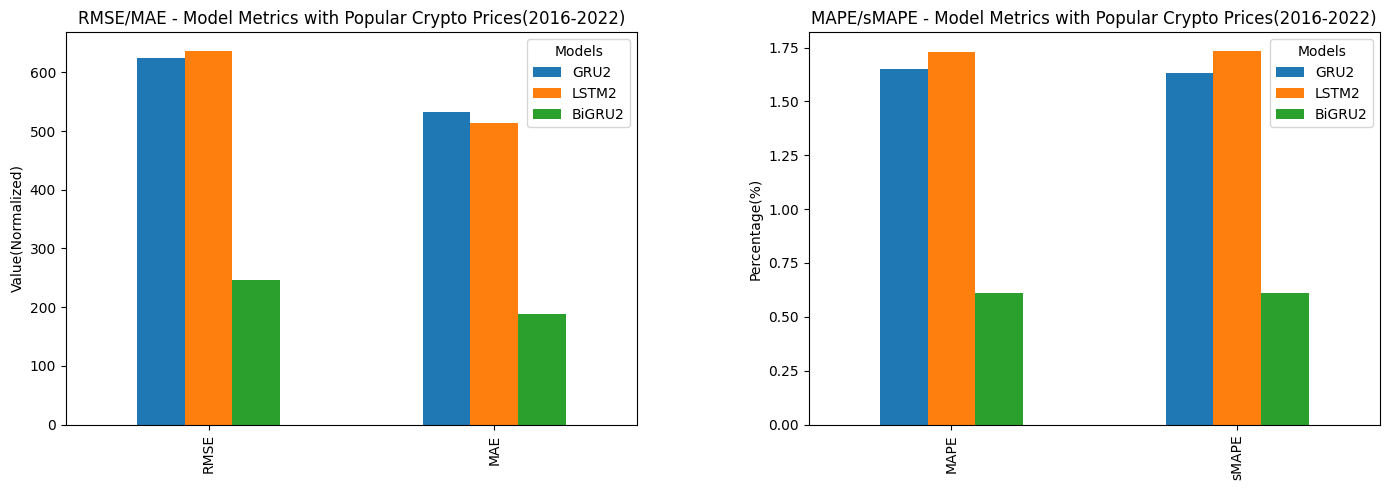

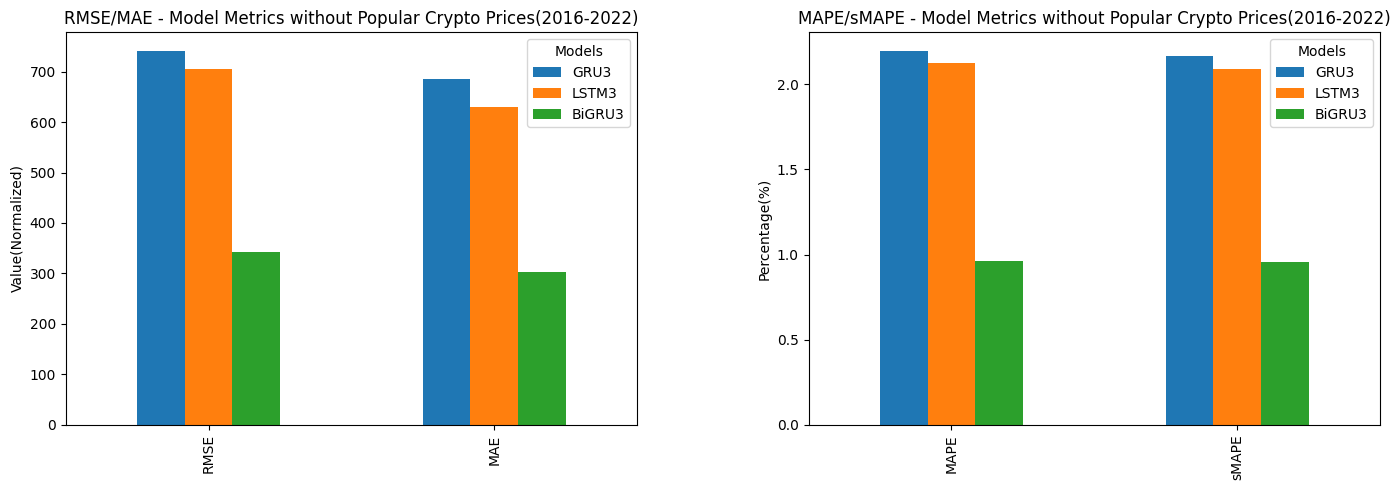

In [ ]:
def plot_model_metrics(filename):
    # Initialize the dictionary
    metrics_dict = {}

    # Define the keys
    keys = ["GRU1", "LSTM1", "BiGRU1", "GRU2", "LSTM2", "BiGRU2", "GRU3", "LSTM3", "BiGRU3"]
    plot_titles = ['Test data (2010-2022)', 'Model Metrics with Popular Crypto Prices(2016-2022)', 'Model Metrics without Popular Crypto Prices(2016-2022)']

    # Open the file
    with open(filename, 'r') as file:
        # Initialize the key index
        key_index = 0

        # Read the file line by line
        for line in file:
            # If the line contains metrics, store them in the dictionary
            if "RMSE" in line:
                metrics_dict[keys[key_index]] = line.strip()
                key_index += 1

    # Parse the metrics and plot for each set of keys
    for i in range(0, len(keys), 3):
        data = {key: [float(value.split(':')[1].strip('%')) if '%' in value else float(value.split(':')[1])
                      for value in metrics_dict[key].split(', ')] for key in keys[i:i+3]}
        
        # Split the data into RMSE/MAE and MAPE/sMAPE
        rmse_mae_data = {key: data[key][:2] for key in data}
        mape_smape_data = {key: data[key][2:] for key in data}
        
        # Plotting
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # Adjust figsize as needed to provide more room
        
        # RMSE/MAE Plot
        df_rmse_mae = pd.DataFrame(rmse_mae_data, index=['RMSE', 'MAE'])
        df_rmse_mae.plot(kind='bar', ax=axs[0])
        axs[0].set_title(f'RMSE/MAE - {plot_titles[i // 3]}')
        axs[0].set_ylabel('Value(Normalized)')
        axs[0].legend(title='Models')
        
        # MAPE/sMAPE Plot
        df_mape_smape = pd.DataFrame(mape_smape_data, index=['MAPE', 'sMAPE'])
        df_mape_smape.plot(kind='bar', ax=axs[1])
        axs[1].set_title(f'MAPE/sMAPE - {plot_titles[i // 3]}')
        axs[1].set_ylabel('Percentage(%)')
        axs[1].legend(title='Models')
        
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.3)  # Increase the spacing between subplots
        plt.show()


plot_model_metrics("model_test_data_metrics.txt")

### Findings so far:

**Objectives recap**:

1. Use machine/deep learning to predict bitcoin closing price in USD(United States Dollar). 
2. Investigate which features are the most important when it comes to making the above prediction. 

**Results summary**:

1. For the period 2010-2022, the GRU model offered the best performance based on RMSE and MAE.
2. For the period 2016-2022, the bidirectional GRU model offered best performance based on RMSE and MAE. 
3. The LSTM model produced the worst overall performance for both time periods based on RMSE and MAE. 
4. The most important features were SMA, EMA, MACD and Signal line. Other popular cryptocurrency prices did not result in better predictions for bitcoin. 
5. The time period for training the models was found to be important as the model trained on the period 2016-2022 produced the best results. 